In [ ]:
import h5py
from google.colab import drive
import glob
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from scipy.ndimage.interpolation import rotate
import random
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim import lr_scheduler
import time
import copy
import csv

torch.manual_seed(17)
random.seed(15)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Get data

In [ ]:
!unzip /content/gdrive/MyDrive/Project.zip

Archive:  /content/gdrive/MyDrive/Project.zip
   creating: Project/
   creating: Project/images/
  inflating: Project/images/ant+hill_102.jpg  
  inflating: Project/images/ant+hill_102_bb.jpg  
  inflating: Project/images/ant+hill_111.jpg  
  inflating: Project/images/ant+hill_111_bb.jpg  
  inflating: Project/images/ant+hill_114.jpg  
  inflating: Project/images/ant+hill_114_bb.jpg  
  inflating: Project/images/ant+hill_126.jpg  
  inflating: Project/images/ant+hill_126_bb.jpg  
  inflating: Project/images/ant+hill_129.jpg  
  inflating: Project/images/ant+hill_129_bb.jpg  
  inflating: Project/images/ant+hill_136.jpg  
  inflating: Project/images/ant+hill_136_bb.jpg  
  inflating: Project/images/ant+hill_15.jpg  
  inflating: Project/images/ant+hill_15_bb.jpg  
  inflating: Project/images/ant+hill_45.jpg  
  inflating: Project/images/ant+hill_45_bb.jpg  
  inflating: Project/images/ant+hill_63.jpg  
  inflating: Project/images/ant+hill_63_bb.jpg  
  inflating: Project/images/ant+hill

In [ ]:
path = "/content/Project"
images_path = path + "/images/"
dataset_path = path + "/SynthText_train.h5"
images = [x for x in glob.glob(images_path + '/*.jpg') if "bb.jpg" not in x]
db = h5py.File(dataset_path, 'r')

#Split data to train and validation

In [ ]:
im_names = list(db['data'].keys())
random.shuffle(im_names)

imgs_train = []
imgs_val = []
fonts_train = []
fonts_val = []
txt_train = []
txt_val = []
charBB_train = []
charBB_val = []
wordBB_train = []
wordBB_val = []
to_train = int(len(im_names)*0.8)
for i, im in enumerate(im_names):
  if i < to_train:
    imgs_train.append(db['data'][im])
    fonts_train.append(db['data'][im].attrs['font'])
    txt_train.append(db['data'][im].attrs['txt'])
    charBB_train.append(db['data'][im].attrs['charBB'].astype('int32'))
    wordBB_train.append(db['data'][im].attrs['wordBB'].astype('int32'))
  else:
    imgs_val.append(db['data'][im])
    fonts_val.append(db['data'][im].attrs['font'])
    txt_val.append(db['data'][im].attrs['txt'])
    charBB_val.append(db['data'][im].attrs['charBB'].astype('int32'))
    wordBB_val.append(db['data'][im].attrs['wordBB'].astype('int32'))

for ind in range(len(fonts_train)):
  fonts_train[ind] = list(fonts_train[ind])

for ind in range(len(fonts_val)):
  fonts_val[ind] = list(fonts_val[ind])

#Create the charecters images and labels for both train and validation

In [ ]:
def out_of_img_correct(img, top, bottom, left, right):
  if top < 0:
    top = 0
  if left < 0:
    left = 0
  if bottom >= img.shape[0]:
    bottom = img.shape[0] - 1
  if right >= img.shape[1]:
    right = img.shape[1] - 1
  return top, bottom, left, right

In [ ]:
font_in_numbers = {b'Titillium Web':0, b'Open Sans':1,
                   b'Ubuntu Mono':2, b'Alex Brush':3, b'Sansation':4}

In [ ]:
def get_X_Y_chars(charBB, imgs, fonts, is_test):
  chars_fonts = []
  chars = []
  original_ind = []
  cur_original_ind = 0
  for ind, img in enumerate(imgs):
    x, y = charBB[ind]
    for i in range(len(x[0])):
      x_top_left = x[0][i]
      x_top_right = x[1][i]
      x_bottom_right = x[2][i]
      x_bottom_left = x[3][i]
      y_top_left = y[0][i]
      y_top_right = y[1][i]
      y_bottom_right = y[2][i]
      y_bottom_left = y[3][i]
      left = min(x_top_left, x_bottom_left)
      right = max(x_top_right, x_bottom_right)
      top = min(y_top_left, y_top_right)
      bottom = max(y_bottom_right, y_top_right)
      top, bottom, left, right = out_of_img_correct(img, top, bottom, left, right)
      if top + 1 >= bottom:
        top, bottom = bottom, top
        bottom += 2
      if left + 1 >= right:
        left, right = right, left
        right += 2
      im = img[top:bottom,left:right]
      #im = np.mean(im, axis=2)  # to gray
      #augmantation = random.choice(augmantations)
      #im = gradient_fill(noise_image(im.astype(np.uint8)))
      #im = rotate(im, angle=(x_top_right-x_top_left))
      #im_tensor = transform_and_resize(im)
      #im = change_view(im)
      chars.append(im)
      if not is_test:
        chars_fonts.append(font_in_numbers[fonts[ind][i]])
        original_ind.append(cur_original_ind)
        cur_original_ind += 1
  #chars = normalize_data(chars)
  if not is_test:
    return chars, chars_fonts, original_ind
  else:
    return chars

In [ ]:
X_train, Y_train, index_train = get_X_Y_chars(charBB_train, imgs_train, fonts_train, False)
X_val, Y_val, index_val = get_X_Y_chars(charBB_val, imgs_val, fonts_val, False)

In [ ]:
def shuffle_data(X, Y, index):
  combined_list = list(zip(X, Y, index))
  random.shuffle(combined_list)
  X_new, Y_new, index_new = zip(*combined_list)
  return list(X_new), list(Y_new), list(index_new)

Shuffel them

In [ ]:
X_train, Y_train, index_train = shuffle_data(X_train, Y_train, index_train)
X_val, Y_val, index_val = shuffle_data(X_val, Y_val, index_val)

#Create data set and loader

In [ ]:
class CharDataSet(Dataset):
  def __init__(self, imgs, labels, transform=None):
    self.imgs = imgs
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    image = self.imgs[index]
    label = self.labels[index]

    if self.transform:
      augmantations = self.transform(image=image)
      image = augmantations['image']

    return image, label

In [ ]:
transform_train = A.Compose(
    [
        A.Resize(224, 224),
        #A.RandomCrop(224, 224),
        #A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.OneOf([
            A.RandomBrightnessContrast(),
            A.ColorJitter(brightness=0.4),
            A.Blur(blur_limit=4, p=0.3)
        ], p=1.0),
        #A.RandomBrightnessContrast(p=0.2),
        #A.ColorJitter(brightness=0.4),
        #A.Blur(blur_limit=3, p=0.5),
        A.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225],
         max_pixel_value=225),
        ToTensorV2()
     ]
     )

transform_val = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225],
         max_pixel_value=225),
        ToTensorV2()
     ]
     )

In [ ]:
chars_train_set = CharDataSet(X_train, Y_train, transform_train)
chars_val_set = CharDataSet(X_val, Y_val, transform_val)

In [ ]:
chars_train_loader = DataLoader(dataset=chars_train_set, batch_size=batch_size)
chars_val_loader = DataLoader(dataset=chars_val_set, batch_size=batch_size)

Count data for each font

b'Titillium Web' has 4367 images.
b'Open Sans' has 4080 images.
b'Ubuntu Mono' has 5574 images.
b'Alex Brush' has 4941 images.
b'Sansation' has 4927 images.


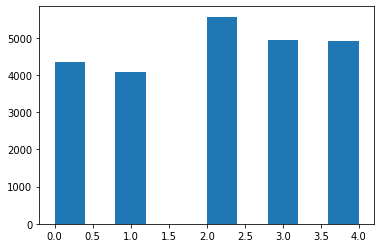

In [ ]:
fonts_in_train = [0 for i in range(5)]
for i in Y_train:
  fonts_in_train[i] += 1

sum_of_fonts = sum(fonts_in_train)

for i in range(5):
  font = [j for j in font_in_numbers if font_in_numbers[j]==i]
  print(f"{font[0]} has {fonts_in_train[i]} images.")
  fonts_in_train[i] = fonts_in_train[i]/sum_of_fonts

counts, bins = np.histogram(Y_train)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fonts_in_train = [0.18280380091255388, 0.17078990330277533, 0.2333291473062916, 0.20683159613211102, 0.20624555234626815]
class_weights = torch.tensor(fonts_in_train)
class_weights = class_weights.to(device=device)

#Train model

In [ ]:
in_channel = 3
num_classes = 5
learning_rate = 0.001
batch_size = 64
num_epochs = 5

In [ ]:
def return_to_original_order(predictions, Y, index):
  combined_list = list(zip(predictions, Y, index))
  combined_list.sort(key=lambda a: a[2])
  predictions_new, Y_new, index_new = zip(*combined_list)
  return predictions_new, Y_new

In [ ]:
def voting(prdictions, txt, original_index_list, Y):
  prdictions, Y_in_order = return_to_original_order(prdictions, Y, original_index_list)
  new_prdictions = []
  pred_ind = 0
  for img in txt:
    for word in img:
      calc_votes = [0 for i in range(5)]
      for c in range(len(word)):
        pred = prdictions[pred_ind][0]
        calc_votes[pred] += prdictions[pred_ind][1]
        pred_ind += 1
      pred_for_word = calc_votes.index(max(calc_votes))
      for i in range(len(word)):
        new_prdictions.append(pred_for_word)
  return new_prdictions, Y_in_order

In [ ]:
def get_accuracy(max_prdictions_in_word, Y):
  num_correct = 0
  num_sampels = len(Y)

  for ind, pred in enumerate(max_prdictions_in_word):
    if pred == Y[ind]:
      num_correct += 1

  print(f"Got {num_correct} / {num_sampels} witn accuracy {float(num_correct)/float(num_sampels)*100:.2f}")

In [ ]:
dataloaders = {"train": chars_train_loader,
               "val": chars_val_loader}
dataset_sizes = {"train": chars_train_set.__len__(),
                 "val": chars_val_set.__len__()}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward - track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def accuracy_and_pred(loader, model):
  classes = list(font_in_numbers.keys())
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  num_correct = 0
  num_sampels = 0
  model.eval()
  pred = []

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)

      scores = model(x)
      scores = F.softmax(scores, dim = 1)
      vals, predictions = scores.max(1)
      num_correct += (predictions==y).sum()
      num_sampels += predictions.size(0)
      for ind, p in enumerate(predictions):
        pred.append([int(p), vals[ind]])

      for label, prediction in zip(y, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  print(f"Got {num_correct} / {num_sampels} witn accuracy {float(num_correct)/float(num_sampels)*100:.2f}")

  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

  model.train()
  return pred

In [ ]:
model1 = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT, progress=False)
model1.classifier = nn.Linear(in_features=1280, out_features=5, bias=True)
model1 = model1.to(device)
model1.train();
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimaizer_model1 = optim.Adam(model1.parameters(), lr=learning_rate)
model1_lr_scheduler = lr_scheduler.StepLR(optimaizer_model1, step_size=7, gamma=0.1)

In [ ]:
model1 = train_model(model1, criterion, optimaizer_model1, model1_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.8936 Acc: 0.6129
val Loss: 0.7094 Acc: 0.6984

Epoch 1/24
----------
train Loss: 0.6250 Acc: 0.7301
val Loss: 0.6303 Acc: 0.7298

Epoch 2/24
----------
train Loss: 0.5140 Acc: 0.7789
val Loss: 0.5654 Acc: 0.7575

Epoch 3/24
----------
train Loss: 0.4460 Acc: 0.8102
val Loss: 0.6298 Acc: 0.7563

Epoch 4/24
----------
train Loss: 0.3949 Acc: 0.8335
val Loss: 0.6271 Acc: 0.7572

Epoch 5/24
----------
train Loss: 0.3496 Acc: 0.8536
val Loss: 0.6416 Acc: 0.7632

Epoch 6/24
----------
train Loss: 0.3171 Acc: 0.8681
val Loss: 0.6754 Acc: 0.7649

Epoch 7/24
----------
train Loss: 0.2089 Acc: 0.9160
val Loss: 0.5576 Acc: 0.8044

Epoch 8/24
----------
train Loss: 0.1450 Acc: 0.9409
val Loss: 0.5952 Acc: 0.8088

Epoch 9/24
----------
train Loss: 0.1195 Acc: 0.9525
val Loss: 0.6231 Acc: 0.8110

Epoch 10/24
----------
train Loss: 0.1044 Acc: 0.9595
val Loss: 0.6528 Acc: 0.8138

Epoch 11/24
----------
train Loss: 0.0887 Acc: 0.9648
val Loss: 0.7031 Acc: 0.8107

Ep

In [ ]:
model1_prdictions_val = accuracy_and_pred(chars_val_loader, model1)

Got 5411 / 6631 witn accurency 81.60
Accuracy for class: b'Titillium Web' is 74.8 %
Accuracy for class: b'Open Sans' is 70.3 %
Accuracy for class: b'Ubuntu Mono' is 88.6 %
Accuracy for class: b'Alex Brush' is 92.4 %
Accuracy for class: b'Sansation' is 77.4 %


In [ ]:
model1_new_prdictions_val, model1_new_Y_val = voting(model1_prdictions_val, txt_val, index_val, Y_val)
get_accuracy(model1_new_prdictions_val, model1_new_Y_val)

Got 5984 / 6631 witn accurency 90.24


#Load model

In [ ]:
def load_model(path):
  model = efficientnet_b0(pretrained=True)
  model.classifier = nn.Linear(in_features=1280, out_features=5, bias=True)
  criterion = nn.CrossEntropyLoss(weight=class_weights)
  optimaizer = optim.Adam(model.parameters(), lr=learning_rate)
  model.load_state_dict(torch.load(path))
  model = model.to(device)
  model.eval()
  return model

In [ ]:
model_save_name = 'model2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model = load_model(path)

In [ ]:
prdictions_val = accuracy_and_pred(chars_val_loader, model)

Got 5449 / 6631 witn accuracy 82.17
Accuracy for class: b'Titillium Web' is 75.9 %
Accuracy for class: b'Open Sans' is 68.0 %
Accuracy for class: b'Ubuntu Mono' is 89.3 %
Accuracy for class: b'Alex Brush' is 93.2 %
Accuracy for class: b'Sansation' is 79.5 %


In [ ]:
new_prdictions_val, new_Y_val = voting(prdictions_val, txt_val, index_val, Y_val)
get_accuracy(new_prdictions_val, new_Y_val)

Got 5977 / 6631 witn accuracy 90.14


#Predict on test set

In [ ]:
def get_pred(loader, model):
  model.eval()
  pred = []

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)

      scores = model(x)
      scores = F.softmax(scores, dim = 1)
      vals, predictions = scores.max(1)
      for ind, p in enumerate(predictions):
        pred.append([int(p), vals[ind]])

  return pred

In [ ]:
dataset_test_path = "/content/gdrive/MyDrive/SynthText_test.h5"
db_test = h5py.File(dataset_test_path, 'r')
im_names_test = list(db_test['data'].keys())
imgs_test = []
txt_test = []
charBB_test = []

for i, im in enumerate(im_names_test):
  imgs_test.append(db_test['data'][im])
  txt_test.append(db_test['data'][im].attrs['txt'])
  charBB_test.append(db_test['data'][im].attrs['charBB'].astype('int32'))

X_test = get_X_Y_chars(charBB_test, imgs_test, [], True)
Y_test = [0 for i in range(len(X_test))]

chars_test_set = CharDataSet(X_test, Y_test, transform_val)
chars_test_loader = DataLoader(dataset=chars_test_set, batch_size=batch_size)

In [ ]:
test_pred = get_pred(chars_test_loader, model)

ind_list = [i for i in range(len(X_test))]

vote_test_pred, _ = voting(test_pred, txt_test, ind_list, Y_test)

In [ ]:
font_labels = ["Titillium Web", "Open Sans", "Ubuntu Mono",
               "Alex Brush", "Sansation"]

data = []
pred_ind = 0
# Add information for each image
for ind, im in enumerate(txt_test):
    image = im_names_test[ind]
    for word in im:
      for c in word:
        font = vote_test_pred[pred_ind]
        font_oh = np.zeros(len(font_labels), dtype=int)
        font_oh[font] = 1
        data.append({"": pred_ind, "image": image, "char": chr(c), font_labels[1]: font_oh[1],
                     font_labels[4]: font_oh[4], font_labels[0]: font_oh[0],
                     font_labels[2]: font_oh[2], font_labels[3]: font_oh[3]})

        pred_ind += 1

with open("/content/gdrive/My Drive/test_results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["", "image", "char", "Open Sans",
               "Sansation", "Titillium Web", "Ubuntu Mono", "Alex Brush"])
    writer.writeheader()
    for row in data:
        writer.writerow(row)